https://phdinds-aim.github.io/time_series_handbook/08_WinningestMethods/lightgbm_m5_forecasting.html

https://www.kaggle.com/code/ratan123/m5-forecasting-lightgbm-with-timeseries-splits

In [1]:
import pandas as pd
import numpy as np

In [2]:
train_df = pd.read_csv("../data/phase0_train.csv")
test_df = pd.read_csv("../data/phase0_test.csv")


In [3]:
train_df.head()

,Client,Warehouse,Product,ds,Price,y
0,0,1,367,2020-07-06,10.900001,7.0
1,0,1,367,2020-07-13,10.900001,7.0
2,0,1,367,2020-07-20,10.900001,7.0
3,0,1,367,2020-07-27,15.582857,7.0
4,0,1,367,2020-08-03,27.289999,7.0


In [4]:
train_df.shape

(2559010, 6)

In [5]:
test_df.shape

(195689, 6)

In [6]:
test_df

,Client,Warehouse,Product,ds,Price,y
0,0,1,367,2023-10-09,51.860000,1.0
1,0,1,367,2023-10-16,51.860000,1.0
2,0,1,367,2023-10-23,51.860000,1.0
3,0,1,367,2023-10-30,51.230000,2.0
4,0,1,367,2023-11-06,51.230000,1.0
...,...,...,...,...,...,...
195684,46,318,14294,2023-12-04,NaN,0.0
195685,46,318,14294,2023-12-11,46.990000,1.0
195686,46,318,14294,2023-12-18,46.990000,1.0
195687,46,318,14294,2023-12-25,39.190000,1.0


In [7]:
df = pd.concat([train_df, test_df])

In [8]:
df = df.reset_index(drop=True)

In [9]:
df = df.sort_values(by  = ['Client', 'Warehouse', 'Product', 'ds'])

In [10]:
df.head()

,Client,Warehouse,Product,ds,Price,y
0,0,1,367,2020-07-06,10.900001,7.0
1,0,1,367,2020-07-13,10.900001,7.0
2,0,1,367,2020-07-20,10.900001,7.0
3,0,1,367,2020-07-27,15.582857,7.0
4,0,1,367,2020-08-03,27.289999,7.0


In [11]:
test_df.tail()

,Client,Warehouse,Product,ds,Price,y
195684,46,318,14294,2023-12-04,NaN,0.0
195685,46,318,14294,2023-12-11,46.990000,1.0
195686,46,318,14294,2023-12-18,46.990000,1.0
195687,46,318,14294,2023-12-25,39.190000,1.0
195688,46,318,14294,2024-01-01,45.423336,3.0


In [12]:
df.tail()

,Client,Warehouse,Product,ds,Price,y
2754694,46,318,14294,2023-12-04,NaN,0.0
2754695,46,318,14294,2023-12-11,46.990000,1.0
2754696,46,318,14294,2023-12-18,46.990000,1.0
2754697,46,318,14294,2023-12-25,39.190000,1.0
2754698,46,318,14294,2024-01-01,45.423336,3.0


In [13]:
cat_cols = ['Client', 'Warehouse', 'Product']
for col in cat_cols:
    df[col] = df[col].astype('category')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2754699 entries, 0 to 2754698
Data columns (total 6 columns):
 #   Column     Dtype   
---  ------     -----   
 0   Client     category
 1   Warehouse  category
 2   Product    category
 3   ds         object  
 4   Price      float64 
 5   y          float64 
dtypes: category(3), float64(2), object(1)
memory usage: 97.6+ MB


In [ ]:
def feature_creation(data, prediction_horizon = 13):
    id_cols = ['Client', 'Warehouse', 'Product']

    data["year"] = data["ds"].dt.year
    data["month"] = data["ds"].dt.month
    data["week"] = data["ds"].dt.isocalendar().week
    data["day"] = data["ds"].dt.day
    data["day_of_week"] = data["ds"].dt.weekday
    data["is_weekend"] = (data["day_of_week"] >= 5).astype(int)  # 1 if Sat/Sun, else 0

    for week in range(prediction_horizon, prediction_horizon+10):#[13,14,15,16,17,18,19]:
        data[f'sales_lag_{week}'] = data.groupby(id_cols, observed=True)['y'].transform(lambda x: x.shift(week))
    
    for week in range(1,14):
        data[f'price_lag_{week}'] = data.groupby(id_cols, observed=True)['Price'].transform(lambda x: x.shift(week))
        data[f'price_rolling_mean_{week}'] = data.groupby(id_cols, observed=True)['Price'].transform(lambda x: x.rolling(week).mean())
        data[f'price_rolling_std_{week}'] = data.groupby(id_cols, observed=True)['Price'].transform(lambda x: x.rolling(week).std())
    
    
    for rolling_window in [13,20,30]:
        data[f'sales_rolling_mean_{rolling_window}'] = data.groupby(id_cols, observed=True)['y'].transform(lambda x: x.shift(prediction_horizon).rolling(rolling_window).mean())
        data[f'sales_rolling_std_{rolling_window}'] = data.groupby(id_cols, observed=True)['y'].transform(lambda x: x.shift(prediction_horizon).rolling(rolling_window).std())

    return data    


In [19]:
data = feature_creation(df, prediction_horizon=1)

In [20]:
data.shape

(2754699, 61)

In [21]:
import gc

In [22]:
gc.collect()

0

In [23]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


In [24]:
# data = reduce_mem_usage(data)

In [25]:
data

,Client,Warehouse,Product,ds,Price,y,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_4,...,price_rolling_std_12,price_lag_13,price_rolling_mean_13,price_rolling_std_13,sales_rolling_mean_13,sales_rolling_std_13,sales_rolling_mean_20,sales_rolling_std_20,sales_rolling_mean_30,sales_rolling_std_30
0,0,1,367,2020-07-06,10.900001,7.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,367,2020-07-13,10.900001,7.0,7.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1,367,2020-07-20,10.900001,7.0,7.0,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,1,367,2020-07-27,15.582857,7.0,7.0,7.0,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1,367,2020-08-03,27.289999,7.0,7.0,7.0,7.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2754694,46,318,14294,2023-12-04,NaN,0.0,2.0,2.0,4.0,3.0,...,NaN,45.04,NaN,NaN,2.692308,1.797434,2.30,1.750188,3.566667,2.674056
2754695,46,318,14294,2023-12-11,46.990000,1.0,0.0,2.0,2.0,4.0,...,NaN,46.99,NaN,NaN,2.384615,1.894662,2.20,1.823819,3.366667,2.709922
2754696,46,318,14294,2023-12-18,46.990000,1.0,1.0,0.0,2.0,2.0,...,NaN,34.09,NaN,NaN,2.230769,1.921538,2.20,1.823819,3.100000,2.523681
2754697,46,318,14294,2023-12-25,39.190000,1.0,1.0,1.0,0.0,2.0,...,NaN,NaN,NaN,NaN,1.923077,1.754116,2.10,1.832456,2.766667,2.062528


In [26]:
test_df.columns

Index(['Client', 'Warehouse', 'Product', 'ds', 'Price', 'y'], dtype='object')

In [27]:
# Remove rows that exist in df_subset
# df_result = df_main.merge(df_subset, on=['ID', 'Value'], how='left', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])

final_train_df = data.merge(test_df[['Client', 'Warehouse', 'Product', 'ds']], on = ['Client', 'Warehouse', 'Product', 'ds'], how = 'left', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])
final_test_df = data.merge(train_df[['Client', 'Warehouse', 'Product', 'ds']], on = ['Client', 'Warehouse', 'Product', 'ds'], how = 'left', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])

In [28]:
x = final_test_df.merge(test_df, on = ['Client', 'Warehouse', 'Product', 'ds'], how = 'outer', indicator=True)
print(x['_merge'].value_counts())
x = final_train_df.merge(train_df, on = ['Client', 'Warehouse', 'Product', 'ds'], how = 'outer', indicator=True)
print(x['_merge'].value_counts())

_merge
both          195689
left_only          0
right_only         0
Name: count, dtype: int64
_merge
both          2559010
left_only           0
right_only          0
Name: count, dtype: int64


In [29]:
# del(x, test_df, train_df, df, data)

In [30]:
gc.collect()

8

In [31]:
final_train_df.reset_index(drop=True, inplace=True)
final_test_df.reset_index(drop=True, inplace=True)

In [32]:
x_train= final_train_df.copy()
x_train.drop(columns=['y'], inplace= True)
y_train = final_train_df['y']

x_test= final_test_df.copy()
x_test.drop(columns=['y'], inplace= True)
y_test = final_test_df['y']

In [33]:
print("Train data shape", x_train.shape, y_train.shape)
print("Test data shape", x_test.shape, y_test.shape)

Train data shape (2559010, 60) (2559010,)
Test data shape (195689, 60) (195689,)


In [34]:
import lightgbm as lgb

In [35]:
# !pip install lightgbm

In [36]:
from sklearn.model_selection import  TimeSeriesSplit

In [37]:
n_fold = 3 #3 for timely purpose of the kernel
folds = TimeSeriesSplit(n_splits=n_fold)

In [38]:
#TODO in fine tuning
params = {'num_leaves': 555,
          'min_child_weight': 0.034,
          'feature_fraction': 0.379,
          'bagging_fraction': 0.418,
          'min_data_in_leaf': 106,
          'objective': 'regression',
          'max_depth': -1,
          'learning_rate': 0.005,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'rmse',
          "verbosity": -1,
          'reg_alpha': 0.3899,
          'reg_lambda': 0.648,
          'random_state': 222,
         }

In [40]:
x_train.columns

Index(['Client', 'Warehouse', 'Product', 'ds', 'Price', 'sales_lag_1',
       'sales_lag_2', 'sales_lag_3', 'sales_lag_4', 'sales_lag_5',
       'sales_lag_6', 'sales_lag_7', 'sales_lag_8', 'sales_lag_9',
       'sales_lag_10', 'price_lag_1', 'price_rolling_mean_1',
       'price_rolling_std_1', 'price_lag_2', 'price_rolling_mean_2',
       'price_rolling_std_2', 'price_lag_3', 'price_rolling_mean_3',
       'price_rolling_std_3', 'price_lag_4', 'price_rolling_mean_4',
       'price_rolling_std_4', 'price_lag_5', 'price_rolling_mean_5',
       'price_rolling_std_5', 'price_lag_6', 'price_rolling_mean_6',
       'price_rolling_std_6', 'price_lag_7', 'price_rolling_mean_7',
       'price_rolling_std_7', 'price_lag_8', 'price_rolling_mean_8',
       'price_rolling_std_8', 'price_lag_9', 'price_rolling_mean_9',
       'price_rolling_std_9', 'price_lag_10', 'price_rolling_mean_10',
       'price_rolling_std_10', 'price_lag_11', 'price_rolling_mean_11',
       'price_rolling_std_11', 'price_

In [42]:
from sklearn import metrics

In [63]:
y_test

0                                                       1.0
1                                                       1.0
2                                                       1.0
3                                                       2.0
4                                                       1.0
                                ...                        
195685                                                  1.0
195686                                                  1.0
195687                                                  1.0
195688                                                  3.0
sales     [5.1491920822820525, 4.447575877340612, 3.1872...
Name: y, Length: 195690, dtype: object

In [43]:
y_test

0         1.0
1         1.0
2         1.0
3         2.0
4         1.0
         ... 
195684    0.0
195685    1.0
195686    1.0
195687    1.0
195688    3.0
Name: y, Length: 195689, dtype: float64

In [52]:
x_train.columns

Index(['Client', 'Warehouse', 'Product', 'ds', 'Price', 'sales_lag_1',
       'sales_lag_2', 'sales_lag_3', 'sales_lag_4', 'sales_lag_5',
       'sales_lag_6', 'sales_lag_7', 'sales_lag_8', 'sales_lag_9',
       'sales_lag_10', 'price_lag_1', 'price_rolling_mean_1',
       'price_rolling_std_1', 'price_lag_2', 'price_rolling_mean_2',
       'price_rolling_std_2', 'price_lag_3', 'price_rolling_mean_3',
       'price_rolling_std_3', 'price_lag_4', 'price_rolling_mean_4',
       'price_rolling_std_4', 'price_lag_5', 'price_rolling_mean_5',
       'price_rolling_std_5', 'price_lag_6', 'price_rolling_mean_6',
       'price_rolling_std_6', 'price_lag_7', 'price_rolling_mean_7',
       'price_rolling_std_7', 'price_lag_8', 'price_rolling_mean_8',
       'price_rolling_std_8', 'price_lag_9', 'price_rolling_mean_9',
       'price_rolling_std_9', 'price_lag_10', 'price_rolling_mean_10',
       'price_rolling_std_10', 'price_lag_11', 'price_rolling_mean_11',
       'price_rolling_std_11', 'price_

In [55]:
columns = list(x_train.columns)
columns.remove('ds')

In [57]:
columns = list(x_train.columns)
columns.remove('ds')
splits = folds.split(x_train, y_train)
y_preds = np.zeros(x_test.shape[0])
y_oof = np.zeros(x_train.shape[0])
feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
mean_score = []
for fold_n, (train_index, valid_index) in enumerate(splits):
    print('Fold:',fold_n+1)
    X_train, X_valid = x_train[columns].iloc[train_index], x_train[columns].iloc[valid_index]
    Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]
    dtrain = lgb.Dataset(X_train, label=Y_train)
    dvalid = lgb.Dataset(X_valid, label=Y_valid)
    clf = lgb.train(params, dtrain, 2500, valid_sets = [dtrain, dvalid])
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    y_pred_valid = clf.predict(X_valid,num_iteration=clf.best_iteration)
    y_oof[valid_index] = y_pred_valid
    val_score = np.sqrt(metrics.mean_squared_error(y_pred_valid, Y_valid))
    print(f'val rmse score is {val_score}')
    mean_score.append(val_score)
    y_preds += clf.predict(x_test[columns], num_iteration=clf.best_iteration)/n_fold
    del X_train, X_valid, Y_train, Y_valid
    gc.collect()
print('mean rmse score over folds is',np.mean(mean_score))
y_test['sales'] = y_preds

Fold: 1
val rmse score is 16.126013375603595
Fold: 2
val rmse score is 36.32719335286525
Fold: 3
val rmse score is 86.67072337553458
mean rmse score over folds is 46.37464336800114


C:\Users\rucha\AppData\Local\Temp\ipykernel_28276\2967467903.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['sales'] = y_preds


In [62]:
x_test.shape

(195689, 60)

In [60]:
y_preds.shape

(195689,)

In [69]:
y_test = y_test[:-1]

In [72]:
test_df['sales_pred'] = y_preds

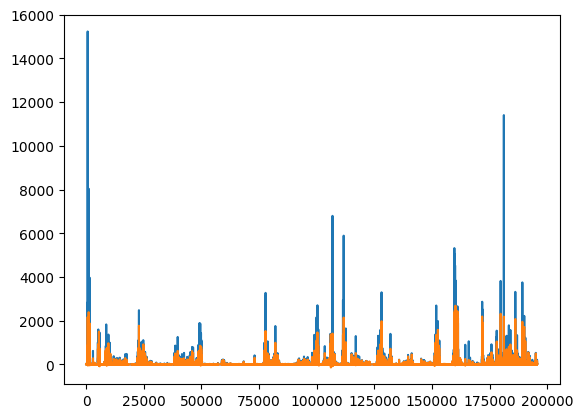

In [87]:
test_df

import matplotlib.pyplot as plt

plt.plot(test_df['y'])
plt.plot(test_df['sales_pred'])

In [88]:
test_df['y'].max()

15236.0

In [89]:
test_df['sales_pred'].max()

2689.621481483054

In [90]:

# s1_naive = series[-29:-1].to_numpy()
# s7_naive = series[-35:-7].to_numpy()
# s30_naive = series[-56:-28].to_numpy()
# s365_naive = series[-364:-336].to_numpy()

In [96]:
id_cols = ['Client', 'Warehouse', 'Product']
df_naive = df.copy()

df_naive['y_pred_naive_13'] = df_naive.groupby(id_cols)['y'].transform(lambda x: x.shift(13))
df_naive['y_pred_naive_26'] = df_naive.groupby(id_cols)['y'].transform(lambda x: x.shift(26))


C:\Users\rucha\AppData\Local\Temp\ipykernel_28276\1334259768.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_naive['y_pred_naive_13'] = df_naive.groupby(id_cols)['y'].transform(lambda x: x.shift(13))
C:\Users\rucha\AppData\Local\Temp\ipykernel_28276\1334259768.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_naive['y_pred_naive_26'] = df_naive.groupby(id_cols)['y'].transform(lambda x: x.shift(26))


In [98]:
df_naive_test = df_naive.merge(
    test_df[['Client', 'Warehouse', 'Product', 'ds']], 
    on = ['Client', 'Warehouse', 'Product', 'ds'], how = 'left', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])

In [84]:
# Custom error metric 
def custom_error(true, pred):
        
    abs_err = np.nansum(np.abs(pred - true))
    err = np.nansum((pred - true))
    score = abs_err + abs(err)
    score /= true.sum().sum()
    return score

In [86]:
custom_error(test_df['y'], y_preds)

0.41965320407243234

In [100]:
custom_error(df_naive['y'], df_naive['y_pred_naive_13'])

0.6607510586761033

In [101]:
custom_error(df_naive['y'], df_naive['y_pred_naive_26'])

0.7540295059531684

In [70]:
y_test

0         1.0
1         1.0
2         1.0
3         2.0
4         1.0
         ... 
195684    0.0
195685    1.0
195686    1.0
195687    1.0
195688    3.0
Name: y, Length: 195689, dtype: object

#### ways of prediction
1. 